# Part 4: Final Transit Parameters

Import Python libraries

In [1]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee
import corner
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Upload the Excel Files containing Transit Fit Parameters

In [2]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')

Define a planetary system.

In [3]:
class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.per = per
        self.per_err = per_err
        
        #PROPERTIES OF THE STAR 
        self.mass = mass  # Solar masses
        self.mass_err = mass_err
        self.radius = radius # Solar radii
        self.radius_err = radius_err
        
        self.teff = teff
        self.teff_err = teff_err
        self.logg = logg
        self.feh = feh
    
        #PROPERTIES OF THE PLANET
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires that Rp be in Earth radii
        
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        
        self.u1 = 0.0 # Claret
        self.u2 = 0.0 # Claret
        self.diffld = 0.0
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.transWindow = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
          
        self.optimize4 = np.empty(0)
        
    def Print(self):
        print("Star {}".format(self.name))

Number of targets that this code will analyze

In [4]:
num = 12

About "tr_window:" Array containing estimates for transit windows (in days). To find them, I initially used a transit window of 20 hours (very big) for all the targets and plotted the folded LC. After visually inspecting it, I made my guesses. Given that these are essentially transit_range*2 (and transit_range is already in days), I chose the transit windows to be twice the range of the transit (I also estimated the range visually, so this process is not perfect. However, it's enough for the code to work and yield good results).

In [5]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.07, 0.08, 0.12, 0.15, 0.08, 0.18, 0.15])
tr_window = transit_range+transit_range # In days

In [6]:
targets = []

for i in range(0, num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    #Logg
    logg = physical["logg"][i]
    feh = physical["feh"][i]
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)

    u1 = 0.0
    u2 = 0.0
    
    # This will upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']

    trange = transit_range[i]
    twind = tr_window[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC)
    
    star.transRange = trange
    star.transWindow = twind 
     
    targets.append(star)

Get the quadratic coefficients for the standard Kepler limb-darkening profile. Model: Claret 2011. 

In [7]:
import kplr
from kplr.ld import get_quad_coeffs

def quadraticLD(star): 
    getmu1, getmu2 = get_quad_coeffs(star.teff, star.logg, star.feh)
    return getmu1, getmu2

for star in targets:
    mu1, mu2 = quadraticLD(star)
    print "Star", star.name, ":", "u1 =", mu1, "u2 =", mu2, "u1-u2 =", mu1-mu2
    star.u1 = mu1
    star.u2 = mu2
    star.diffld = mu1-mu2

Star 201516974 : u1 = 0.7867 u2 = -0.0114 u1-u2 = 0.7981
Star 201920032 : u1 = 0.4089 u2 = 0.2556 u1-u2 = 0.1533
Star 205924614 : u1 = 0.678 u2 = 0.0894 u1-u2 = 0.5886
Star 205985357 : u1 = 0.4415 u2 = 0.2396 u1-u2 = 0.2019
Star 206029314 : u1 = 0.4906 u2 = 0.1813 u1-u2 = 0.3093
Star 206038483 : u1 = 0.4089 u2 = 0.2556 u1-u2 = 0.1533
Star 206061524 : u1 = 0.6656 u2 = 0.0853 u1-u2 = 0.5803
Star 206082454 : u1 = 0.3858 u2 = 0.2711 u1-u2 = 0.1147
Star 206155547 : u1 = 0.3277 u2 = 0.2981 u1-u2 = 0.0296
Star 206245553 : u1 = 0.3643 u2 = 0.2807 u1-u2 = 0.0836
Star 206247743 : u1 = 0.5362 u2 = 0.1609 u1-u2 = 0.3753
Star 206311743 : u1 = 0.5508 u2 = 0.1646 u1-u2 = 0.3862


/Users/mbadenas/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Run the code

In [8]:
def processStar(star):
    
    #Clean LC (remove points above 3 sigma)
    goodP = intro(star) 
    
    # Print old values for the period and midtransit time 
    old_per =  star.per
    old_t0 = star.midts
    print "Old period:", old_per
    print "Old t0:", old_t0
    print ""    
    
    # Upload best guesses for period and overall t0    
    info = np.loadtxt('3_'+star.name+'finalp0t0.txt', skiprows=1)
    star.per = info[0,0]
    star.midts = info[1,0]
    
    #Print new values for the period and midtransit time
    print "New period: ", star.per
    print "New t0: ", star.midts
    print ""
   
    mark_transits(star)  #Identify transits in the data 
    new_error = outliers(star) #remove >3sigma outliers for the new LC and give new std
    
    print "New standard dev:", new_error
    old_error = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1) [8] # Upload old stdv
    print "Old standard dev:", old_error
    
    transit_window(star, goodP) #Create phase-folded LC with new values of period and overall t0
    out_transit(star)
    oot_fit(star)

In [9]:
def intro(star): #Clean LC (remove points above 3 sigma)
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

In [10]:
def outliers(star):
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux + 3*errorLC
    star.fluxLC = star.fluxLC[goodPoints]
    star.timeLC = star.timeLC[goodPoints]
    new_err = np.std(star.fluxLC)
    star.error_foldedLC = new_err
    return new_err

In [11]:
def out_transit(star):
    # print "Range of the transit (visual estimate):", star.transRange
    dataBool = np.abs(star.dt) >= star.transRange # If true, point is outside of the transit.
    out = (star.t_trans <= star.transRange) & (star.t_trans >= star.transRange) # Boolean array. Tells which points are outside the transit.
    return out

In [12]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -30
    maxepoch = 30
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits

In [13]:
def transit_window(star, goodP): #Select the points that are "transit_window" hours to the left & right of the transit.
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    window = star.transWindow # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0, len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans # time w.r.t. midtransit. 
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

For each individual transit: perform a linear fit to the out-of-transit regions.

In [14]:
def oot_fit(star): 
    
    corFlux = star.f_trans
    
    for i in range(0, len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            #corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
            
        else: 
            star.transits[i] = 0.0
   
    # ------- Fix length of star.transits vector (if necessary) ------- 
    
    new_a = np.empty(0)
     
    for k in range(0, len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a
    
    # ------- Fix length of star.flag, star.f_trans, star.t_trans, and star.dt vectors (if necessary)
    
    sumPoints = 0
    
    for i in range(0, len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.t_trans[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.f_trans[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.t_trans = t_trans 
    star.f_trans = f_trans 
    star.dt = dT
    
    # Divide the "light curve" of each transit by the fit obtained in the previous window.
    
    corFlux2 = star.f_trans
    
    for i in range(0, len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux2[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) 

In [15]:
new_targets = np.empty(0)

for i in range(0, len(targets)):    
    if (targets[i].name != "205985357") and (targets[i].name != "206247743") and (targets[i].name != "206311743"):
        new_targets = np.append(new_targets, targets[i])
        
for star in new_targets:
    print "Star ", star.name
    
print len(new_targets)

#  205985357: False Positive
#  206247743: False Positive 
#  206311743: False Positive

Star  201516974
Star  201920032
Star  205924614
Star  206029314
Star  206038483
Star  206061524
Star  206082454
Star  206155547
Star  206245553
9



 ** Star  201516974 **

Old period: 36.7098909842
Old t0: 1986.80555162

New period:  36.72503659
New t0:  1986.79440402

New standard dev: 0.000786259116833
Old standard dev: 0.00090608313


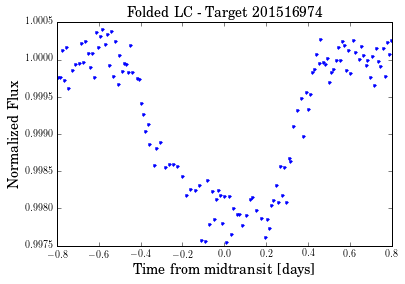

------------------------------------------------------------

 ** Star  201920032 **

Old period: 28.2716715297
Old t0: 2000.205774

New period:  28.2716926045
New t0:  2000.20375062

New standard dev: 0.000264378530054
Old standard dev: 0.00035930069


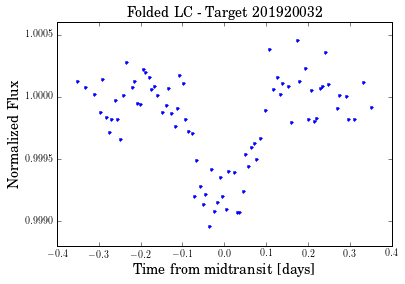

------------------------------------------------------------

 ** Star  205924614 **

Old period: 2.8493410352
Old t0: 2150.424485

New period:  2.8492854753
New t0:  2150.42286341

New standard dev: 0.000911775381207
Old standard dev: 0.00148136477


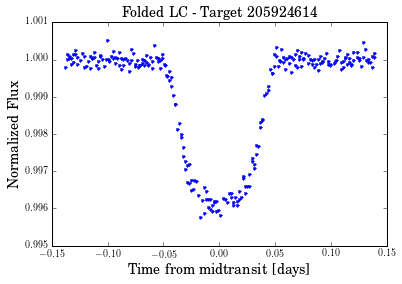

------------------------------------------------------------

 ** Star  206029314 **

Old period: 7.0260433213
Old t0: 2148.06875

New period:  7.0263836189
New t0:  2148.06473542

New standard dev: 0.0113899502161
Old standard dev: 0.01357206052


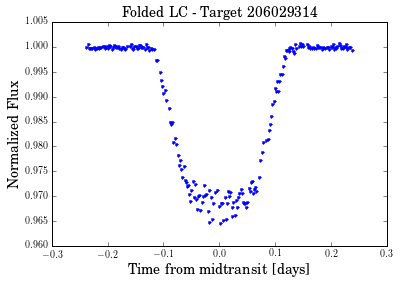

------------------------------------------------------------

 ** Star  206038483 **

Old period: 3.00258097652
Old t0: 2149.05976

New period:  3.0026252211
New t0:  2149.05988737

New standard dev: 0.00168995870224
Old standard dev: 0.00208533311


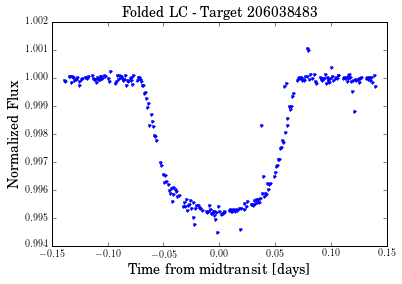

------------------------------------------------------------

 ** Star  206061524 **

Old period: 5.87969688905
Old t0: 2153.323933

New period:  5.8793793165
New t0:  2153.32436576

New standard dev: 0.00283757688138
Old standard dev: 0.00351527683


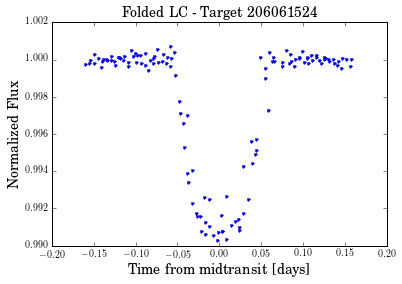

------------------------------------------------------------

 ** Star  206082454 **

Old period: 29.6259825117
Old t0: 2160.54021572

New period:  29.62590845
New t0:  2160.540277

New standard dev: 0.00046728531521
Old standard dev: 0.00056777951


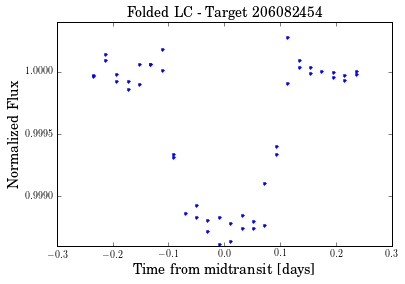

------------------------------------------------------------

 ** Star  206155547 **

Old period: 24.3872033754
Old t0: 2152.884148

New period:  24.3873658957
New t0:  2152.88459268

New standard dev: 0.009103404721
Old standard dev: 0.01036184501


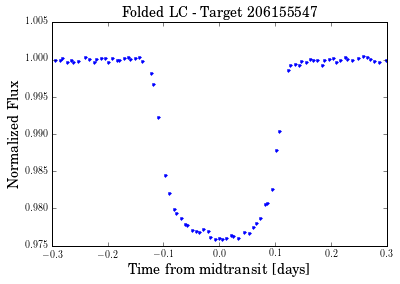

------------------------------------------------------------

 ** Star  206245553 **

Old period: 7.49495298435
Old t0: 2154.672782

New period:  7.4954812744
New t0:  2154.67255725

New standard dev: 0.000209208148046
Old standard dev: 0.0002698681


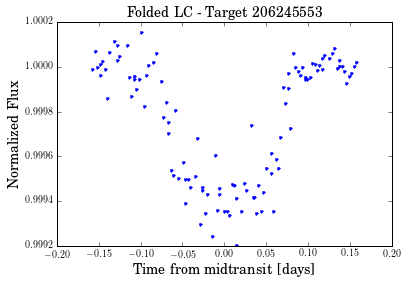

------------------------------------------------------------



In [16]:
print "WARNING: If old & new period are the same, run again the code from the beginning!"
print ""
for star in new_targets:
    print " ** Star ", star.name, "**"
    print ""
    processStar(star)
    
    # Plot the phase-folded light curve: star.dt vs. star.f_trans
    fig = plt.figure() 
    plt.plot(star.dt, star.f_trans,'.') 
    plt.title('Folded LC - Target ' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.xlabel('Time from midtransit [days]', fontsize = 14)
    plt.savefig('4_'+star.name+'final_foldedLC.jpg', dpi=800)
    plt.show()
    
    folded_time = star.dt
    folded_flux = star.f_trans
    
    argsorts = np.argsort(folded_time)
    
    folded_time = folded_time[argsorts]
    folded_flux = folded_flux[argsorts]
    
    l = len(folded_time)
    error = np.empty(l, dtype = object)
    
    for i in range(0,l):
        error[i] = 0.0001
        
    np.savetxt('4_folded' + star.name +'.csv', np.transpose([folded_time, folded_flux, error]), 
               delimiter=' ', fmt='%0.6f')
    plt.show()
    
    print "------------------------------------------------------------"
    print ""

## Fit Phase-Folded Light Curves

Likelihood function that will help me find the best transit parameters and their uncertainties



In [17]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior) #solar radii
    theta[7] = f0 = the out of eclipse flux
    """
    
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = np.abs(pmass), radius = pradius))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period = period, t0 = pt0, b = np.abs(pb), e = ecc)
    s.add_body(body)
    
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    try:
        ftheo = s.light_curve(timeLC, texp = tKep, tol = 1e-8, maxdepth = 4)
    
    except ValueError:
        return -np.inf
        
    ftheo = ftheo - 1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

Define the probability function as likelihood * prior.

In [18]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
   
    if (0 <= pb < 1.5) and (pdepth > 0) and (0 <= sigma) and (0 < pradius < 2.5) and (pmass > 0) and (0.4 < sumLD < 1.0):
        return 0.0
    
    return -np.inf

In [19]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    
    if not np.isfinite(lp):
        return -np.inf 
    
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

Optimization for target 201516974 ...
Optimization terminated successfully.
         Current function value: -945.600705
         Iterations: 986
         Function evaluations: 1451
-> Optimal parameters:
      Depth: 0.0026825020189
      Impact parameter b: 0.886937288579
      Initial transit time: -0.00105114698077
      Sum of quadratic LD coefficients: 0.787235046385
      Sigma (additional white noise term): 1.36639381449e-10
      Mass of the star (Solar units): 0.0124696557891
      Radius of the star (Solar units): 1.51786978594
      Out-of-transit Flux: 1.00002222108



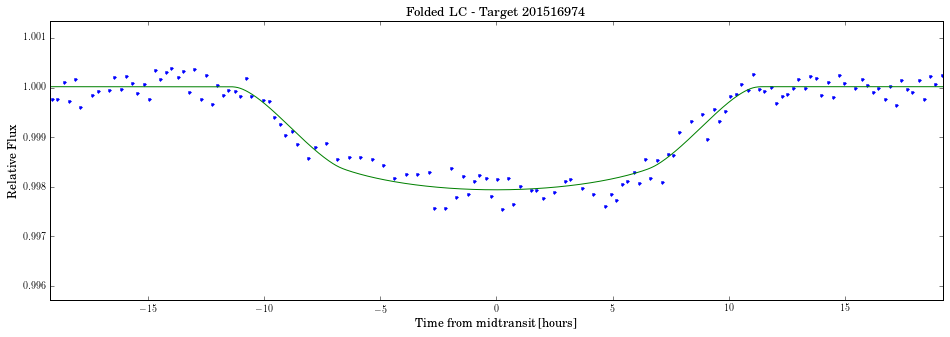

Optimization for target 201920032 ...
Optimization terminated successfully.
         Current function value: -667.927157
         Iterations: 402
         Function evaluations: 662
-> Optimal parameters:
      Depth: 0.000628231690129
      Impact parameter b: 0.0141315655537
      Initial transit time: -0.000694493402364
      Sum of quadratic LD coefficients: 0.773724922714
      Sigma (additional white noise term): 1.59171713995e-06
      Mass of the star (Solar units): 0.998733671091
      Radius of the star (Solar units): 0.770166630753
      Out-of-transit Flux: 1.00001429263



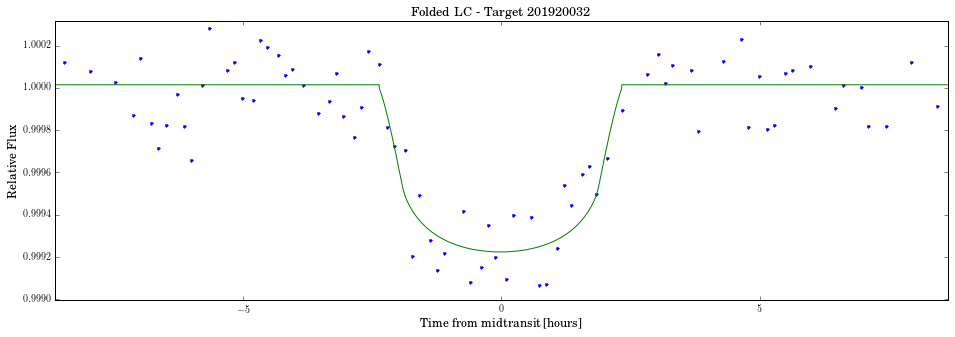

Optimization for target 205924614 ...
Optimization terminated successfully.
         Current function value: -1746.179957
         Iterations: 548
         Function evaluations: 839
-> Optimal parameters:
      Depth: 0.00303134806148
      Impact parameter b: 0.118513296897
      Initial transit time: -3.03879838247e-06
      Sum of quadratic LD coefficients: 0.753043329913
      Sigma (additional white noise term): 8.12004940449e-07
      Mass of the star (Solar units): 0.704274873626
      Radius of the star (Solar units): 0.670060902807
      Out-of-transit Flux: 0.999998158604



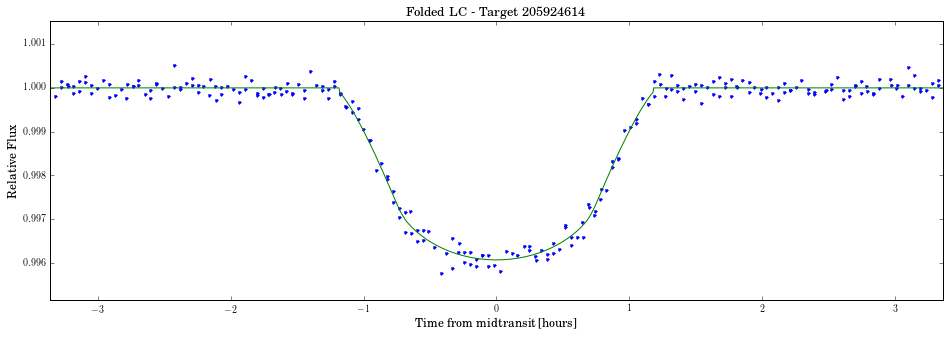

Optimization for target 206029314 ...
Optimization terminated successfully.
         Current function value: -954.320174
         Iterations: 705
         Function evaluations: 1043
-> Optimal parameters:
      Depth: 0.026713357526
      Impact parameter b: 0.014999510652
      Initial transit time: 0.00239613224106
      Sum of quadratic LD coefficients: 0.4545387547
      Sigma (additional white noise term): 3.21401481166e-10
      Mass of the star (Solar units): 0.747199042576
      Radius of the star (Solar units): 1.14277665311
      Out-of-transit Flux: 0.999437946763



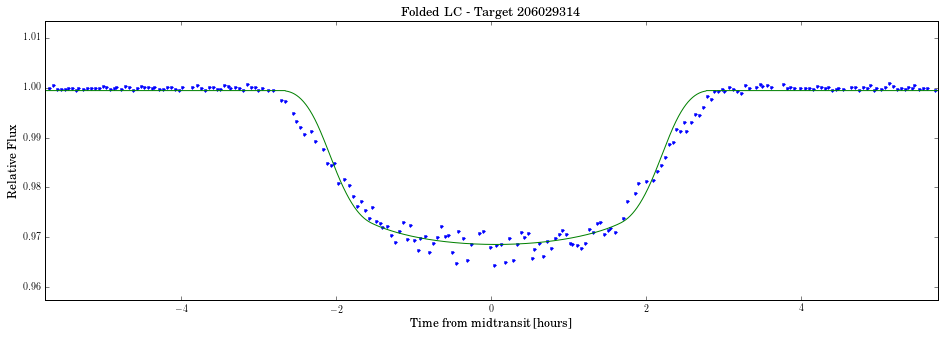

Optimization for target 206038483 ...
Optimization terminated successfully.
         Current function value: -1611.499170
         Iterations: 287
         Function evaluations: 459
-> Optimal parameters:
      Depth: 0.00381855134835
      Impact parameter b: 0.0753222474793
      Initial transit time: -0.000763716801892
      Sum of quadratic LD coefficients: 0.78776060134
      Sigma (additional white noise term): 5.4482802181e-06
      Mass of the star (Solar units): 0.972996443001
      Radius of the star (Solar units): 1.1043489978
      Out-of-transit Flux: 1.00000292258



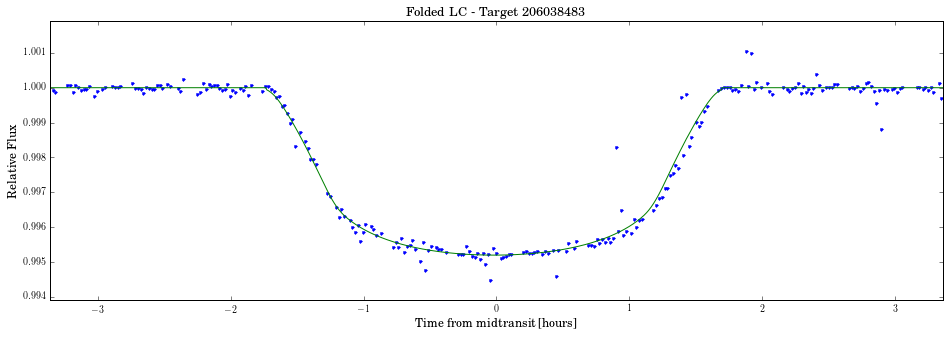

Optimization for target 206061524 ...
Optimization terminated successfully.
         Current function value: -753.612625
         Iterations: 685
         Function evaluations: 1026
-> Optimal parameters:
      Depth: 0.00772961900587
      Impact parameter b: 0.400897762602
      Initial transit time: 0.00045024432335
      Sum of quadratic LD coefficients: 0.571328795533
      Sigma (additional white noise term): 7.02684783919e-08
      Mass of the star (Solar units): 0.649066232415
      Radius of the star (Solar units): 0.622408688329
      Out-of-transit Flux: 0.999978676407



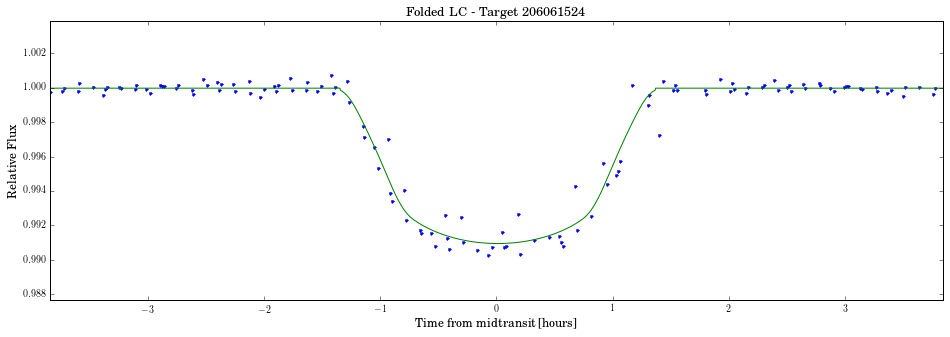

Optimization for target 206082454 ...
Optimization terminated successfully.
         Current function value: -351.923424
         Iterations: 322
         Function evaluations: 505
-> Optimal parameters:
      Depth: 0.000983587117545
      Impact parameter b: 0.0670638122329
      Initial transit time: -3.99635918912e-05
      Sum of quadratic LD coefficients: 0.935152855758
      Sigma (additional white noise term): 4.14024118603e-10
      Mass of the star (Solar units): 0.906349619423
      Radius of the star (Solar units): 0.844964525136
      Out-of-transit Flux: 1.00001471196



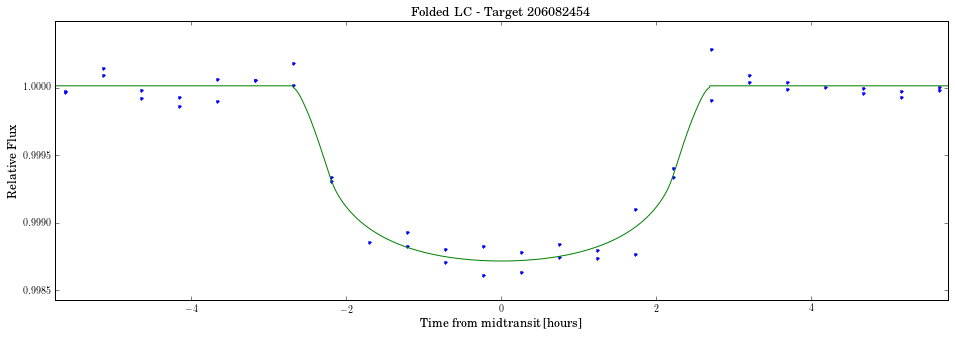

Optimization for target 206155547 ...
Optimization terminated successfully.
         Current function value: -380.564919
         Iterations: 745
         Function evaluations: 1096
-> Optimal parameters:
      Depth: 0.0215870323052
      Impact parameter b: 0.50713391556
      Initial transit time: -9.40864640993e-05
      Sum of quadratic LD coefficients: 0.542365709213
      Sigma (additional white noise term): 4.82492853186e-08
      Mass of the star (Solar units): 1.18141459971
      Radius of the star (Solar units): 1.22042875401
      Out-of-transit Flux: 1.00000186775



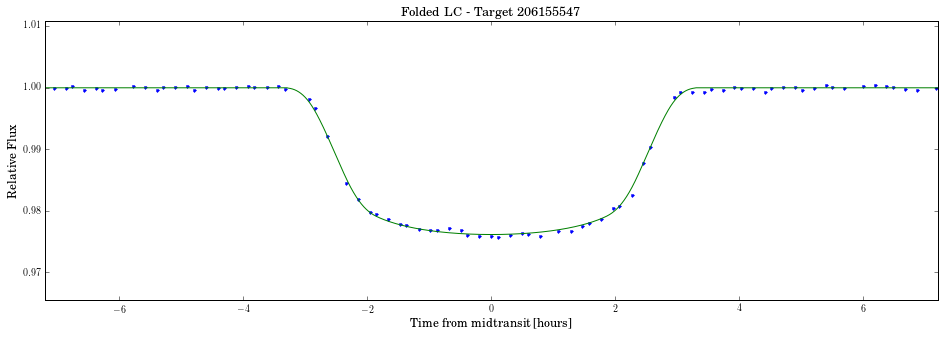

Optimization for target 206245553 ...
Optimization terminated successfully.
         Current function value: -922.865881
         Iterations: 433
         Function evaluations: 670
-> Optimal parameters:
      Depth: 0.000485294601658
      Impact parameter b: 0.324647682924
      Initial transit time: 0.000231318518335
      Sum of quadratic LD coefficients: 0.769837040624
      Sigma (additional white noise term): 1.94970169195e-11
      Mass of the star (Solar units): 1.07086722052
      Radius of the star (Solar units): 1.06407858435
      Out-of-transit Flux: 0.999999073652



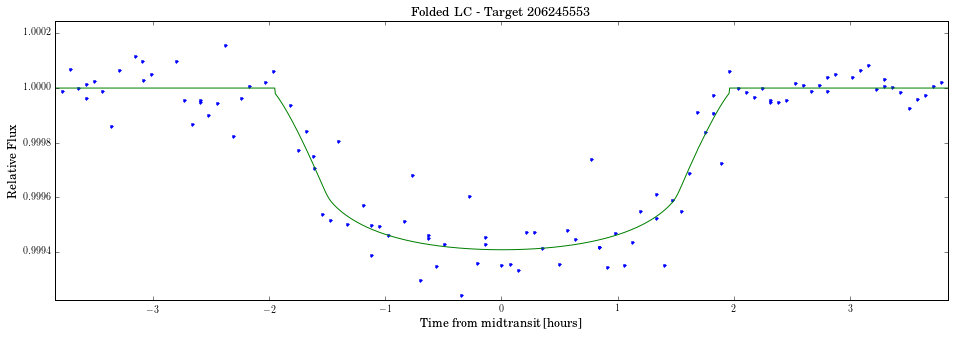

In [21]:
for star in new_targets:
    print "Optimization for target", star.name, "..."
    
    #Upload clean folded light curve 
    data = pd.read_table('4_folded' + star.name +'.csv', delimiter=' ', header = None, names=['time', 'flux', 'error'])
    
    star.dt = data['time']
    star.f_trans = data['flux']
    
    # Upload best guesses obtained in Part 1:
    parameters_ml = np.loadtxt('1_'+ star.name +'guesses.txt', skiprows=1)
    depth_ml = parameters_ml[0]
    b_ml = parameters_ml[1]
    t0_ml = parameters_ml[2]
    sigma_ml = parameters_ml[3]
    sumLD_ml = parameters_ml[4]
    mass_ml = parameters_ml[5]
    radius_ml = parameters_ml[6]
    f0_ml = parameters_ml[7]
 
    # Fixed Variables: 
    allfixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
 
    #Optimize parameters
    n3 = lambda *args: -lnprob(*args)
    result = op.minimize(n3, [depth_ml, np.abs(b_ml), 0.0, sigma_ml, 0.6, mass_ml, radius_ml, f0_ml], 
                         args = (star.dt, star.f_trans, star.error_foldedLC, allfixed), 
                         options={'disp': True}, 
                         method='Nelder-Mead')
    
    # Store and print the new best estimates 
    depth_ml2, b_ml2, t0_ml2, sigma_ml2, sumLD_ml2, mass_ml2, radius_ml2, f0_ml2 = result["x"]

    star.optimize4 = result["x"]
    
    print "-> Optimal parameters:"
    print "      Depth:", depth_ml2
    print "      Impact parameter b:", b_ml2
    print "      Initial transit time:", t0_ml2
    print "      Sum of quadratic LD coefficients:", sumLD_ml2
    print "      Sigma (additional white noise term):", sigma_ml2
    print "      Mass of the star (Solar units):", mass_ml2
    print "      Radius of the star (Solar units):", radius_ml2
    print "      Out-of-transit Flux:", f0_ml2
    print ""

    #Update coefficients
    u1_ml2 = 0.5*(sumLD_ml2 + star.diffld)
    u2_ml2 = sumLD_ml2-u1_ml2
    
    #Update  parameters
    star.u1 = u1_ml2
    star.u2 = u2_ml2
    star.mass = mass_ml2
    star.radius = radius_ml2
    star.depth = depth_ml2
    star.b = b_ml2 
    
    # Compute each transit LC integrated over a Kepler long cadence exposure time with 
    #the result derived from optimization and plot theoretical model and observed data.
    
    s = transit.System(transit.Central(mu1 = star.u1, mu2 = star.u2, mass = star.mass, radius = star.radius))
    
    body = transit.Body(r = np.sqrt(star.depth)*star.radius, period = star.per, 
                        t0 = t0_ml2, b = np.abs(star.b), e = star.ecc)
    s.add_body(body)

    t_theory = np.arange(-1, 1, tKep*0.01)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-08, maxdepth = 4)
    f_theory = f_theory - 1.0 + f0_ml2

    fig = plt.figure(figsize=(16,5))
    plt.plot(24.0*star.dt, star.f_trans, '.') #Plot folded LC (note: dt is now in hours)
    plt.plot(24.0*t_theory, f_theory)
    plt.title('Folded LC - Target ' + star.name, fontsize = 13)
    plt.xlabel('Time from midtransit [hours]', fontsize = 12)
    plt.ylabel('Relative Flux', fontsize = 12)
    plt.xlim([-star.transWindow*24.0, star.transWindow*24.0]) 
    plt.ylim([1-star.depth*1.6, star.depth*0.5+1]) 
    plt.savefig('4_'+star.name+'model_foldedLC.png', dpi = 700)
    plt.show()
        
    #b=0 centre of stellar disk & b=1 at the cusp of the disc

## Final MCMC

With the best fit solutions, we'll run an MCMC routine to estimate the uncertainties on the parameters.

Analysis of: 201516974
Model parameters:
      Depth: 0.0026825020189
      Impact parameter b: 0.886937288579
      Initial transit time: -0.00105114698077
      Sigma: 1.36639381449e-10
      Sum of quadratic LD coefficients: 0.787235046385
      Mass of the star (Earth units): 0.0124696557891
      Radius of the star (Earth units): 1.51786978594
      Out-of-transit Flux: 1.00002222108

Running MCMC...
Done.


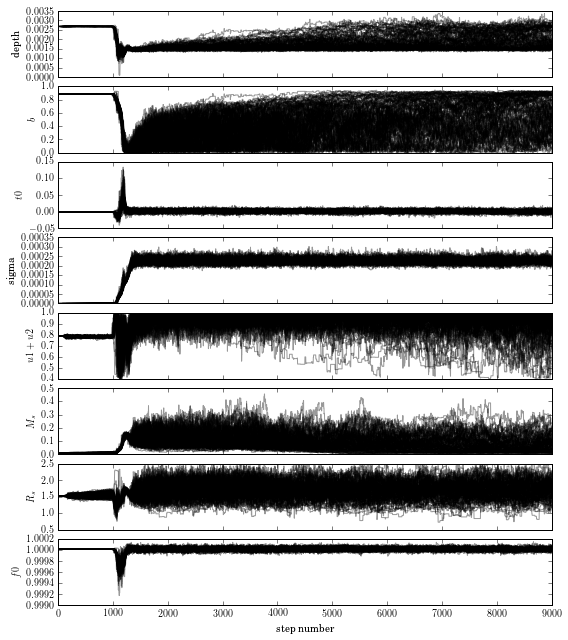

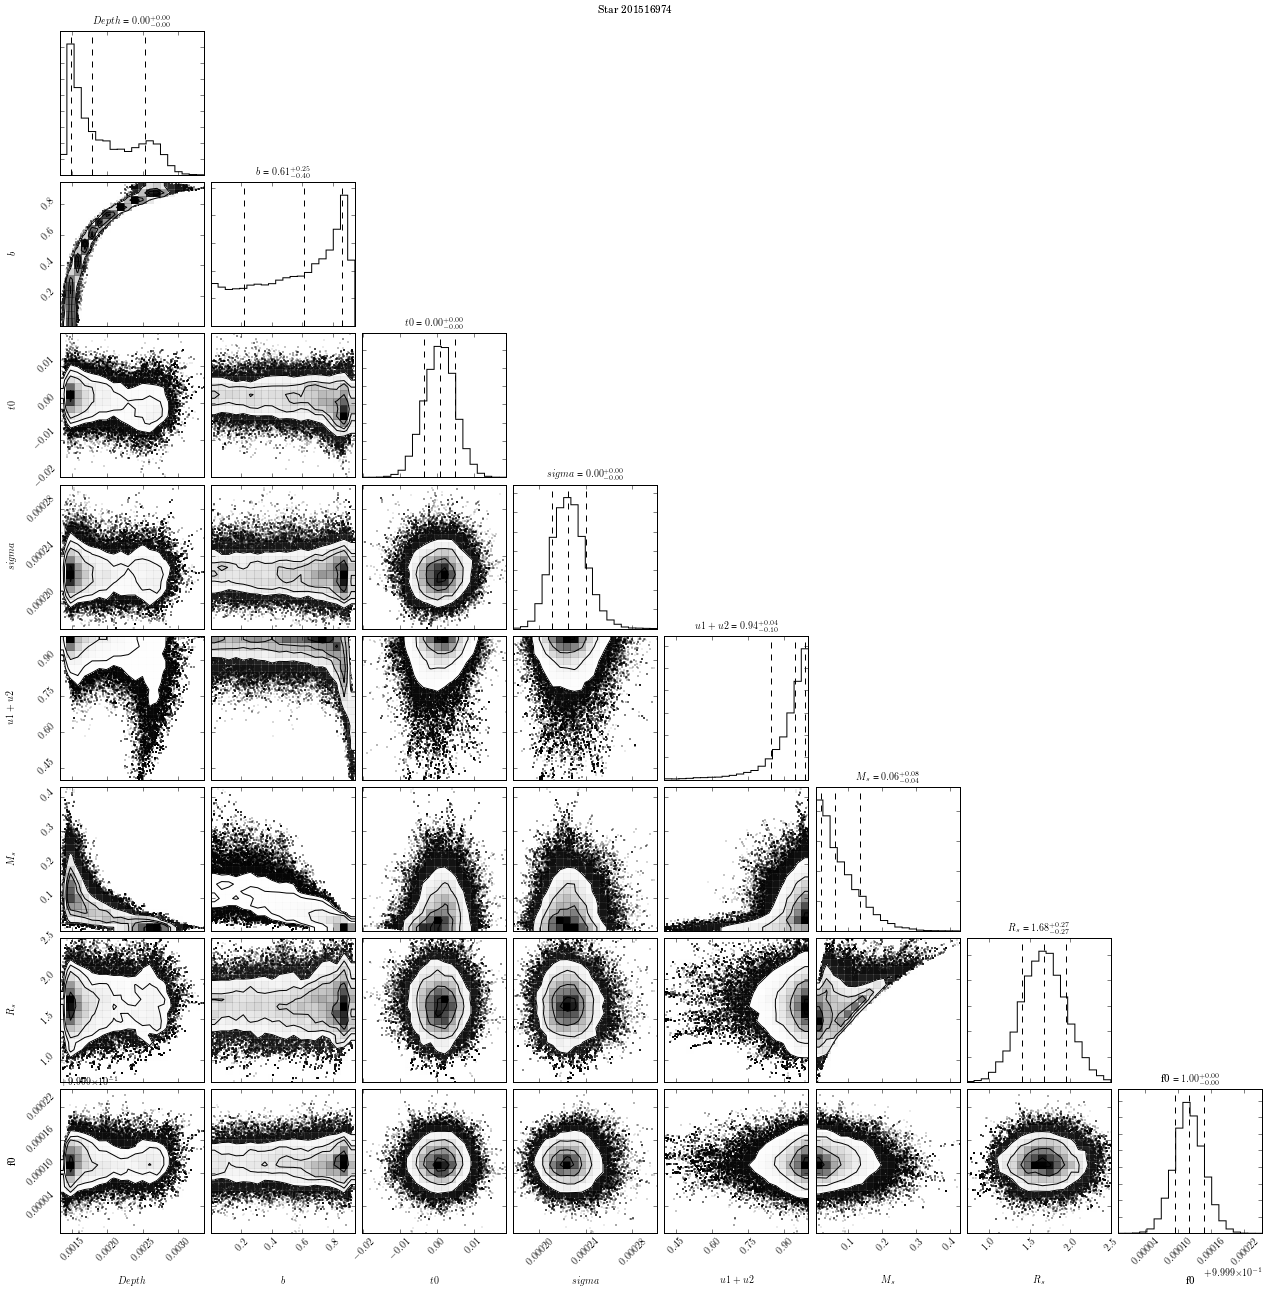

Mean acceptance fraction: 0.235

Autocorrelation time: [ 97.49446977  97.79836883  76.53043644  97.92773671  95.31454142
  97.48626176  94.34598724  91.40976519]
(7.8191462526720388, 1.857961551974566, 1.4091703067629879)
(0.088665926566530051, 0.042690419259290346, 0.016578431097543145)

----------------------------------------------------------------------------------------------------
Analysis of: 206061524
Model parameters:
      Depth: 0.00772961900587
      Impact parameter b: 0.400897762602
      Initial transit time: 0.00045024432335
      Sigma: 7.02684783919e-08
      Sum of quadratic LD coefficients: 0.571328795533
      Mass of the star (Earth units): 0.649066232415
      Radius of the star (Earth units): 0.622408688329
      Out-of-transit Flux: 0.999978676407

Running MCMC...
Done.


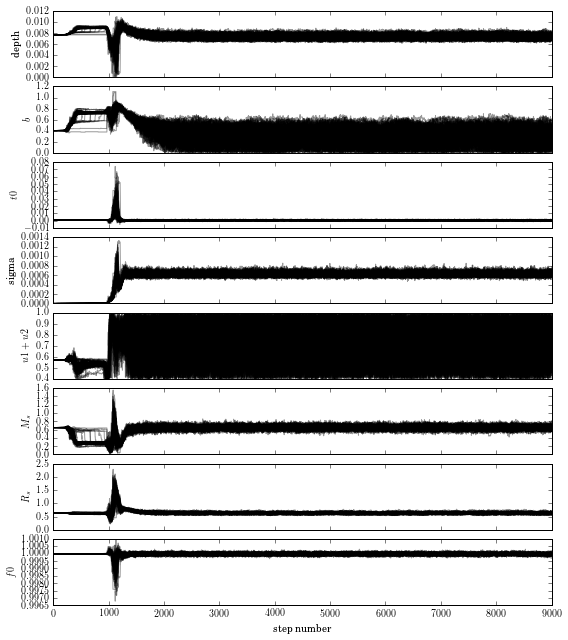

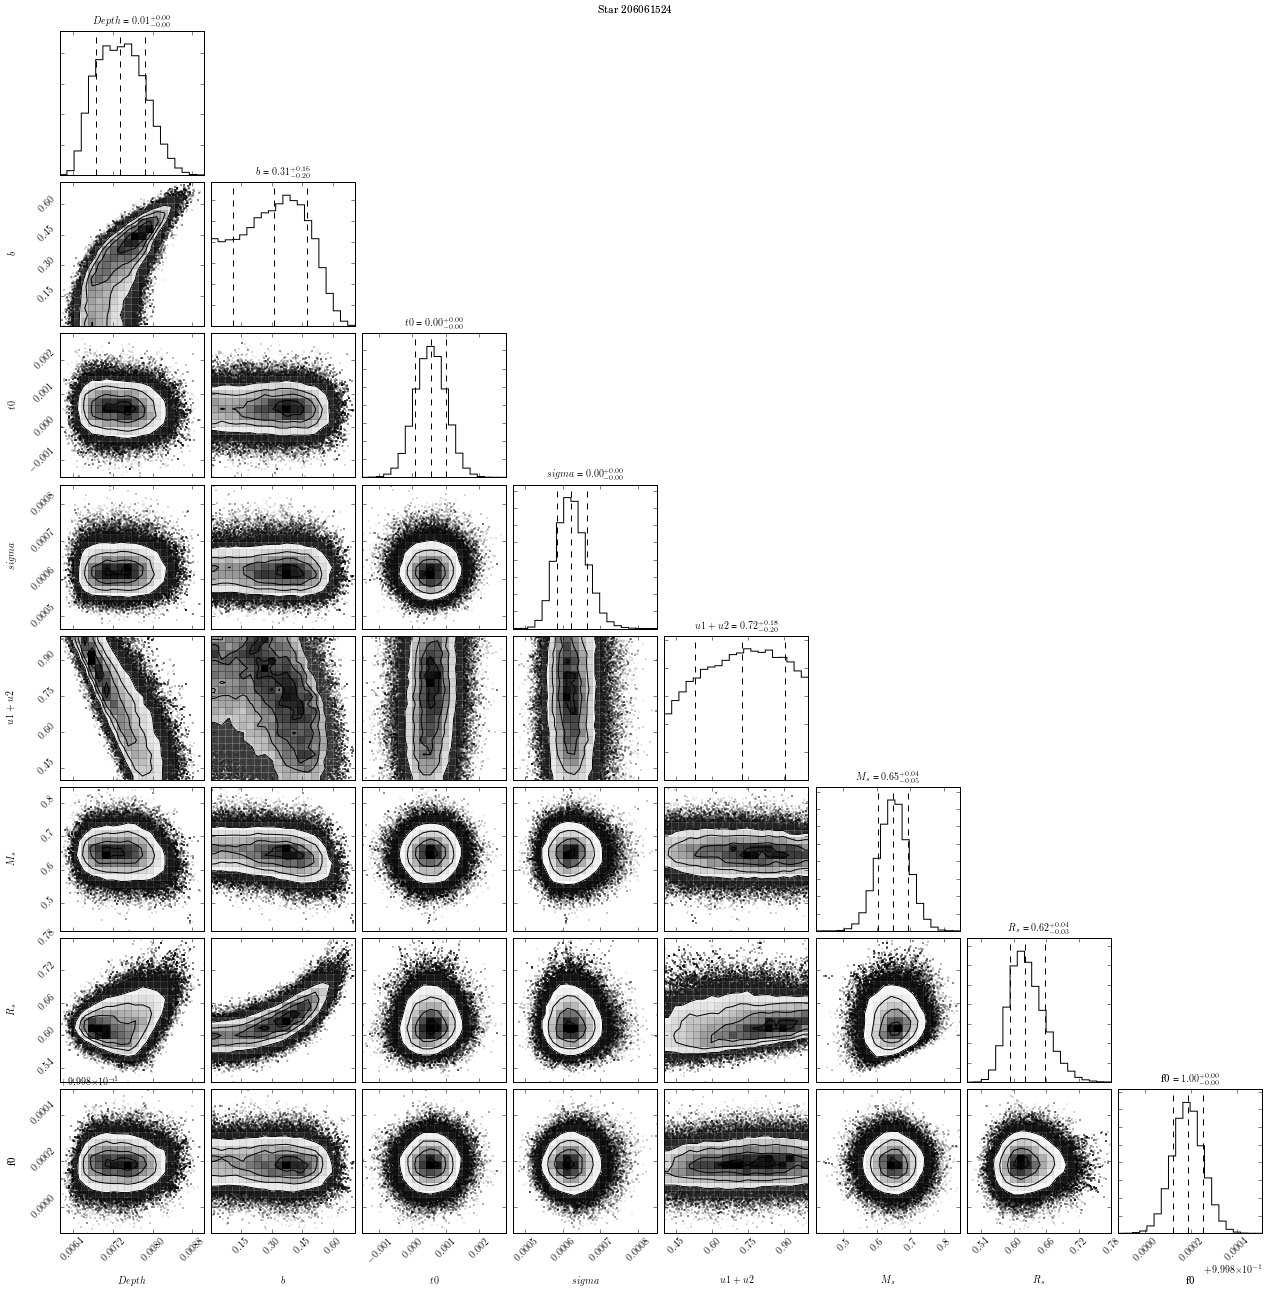

Mean acceptance fraction: 0.347

Autocorrelation time: [ 93.59409803  98.37213207  83.76812891  97.53419526  92.96600063
  95.60230257  87.33526749  75.10170063]
(5.7636840569446024, 0.51738432909064347, 0.30763630308114642)
(0.052328809589509008, 0.0034799852691989736, 0.0023912401435122813)

----------------------------------------------------------------------------------------------------
Analysis of: 206245553
Model parameters:
      Depth: 0.000485294601658
      Impact parameter b: 0.324647682924
      Initial transit time: 0.000231318518335
      Sigma: 1.94970169195e-11
      Sum of quadratic LD coefficients: 0.769837040624
      Mass of the star (Earth units): 1.07086722052
      Radius of the star (Earth units): 1.06407858435
      Out-of-transit Flux: 0.999999073652

Running MCMC...
Done.


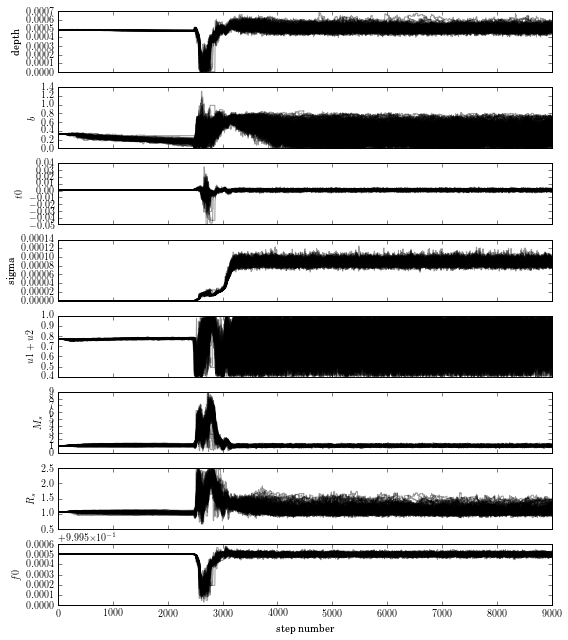

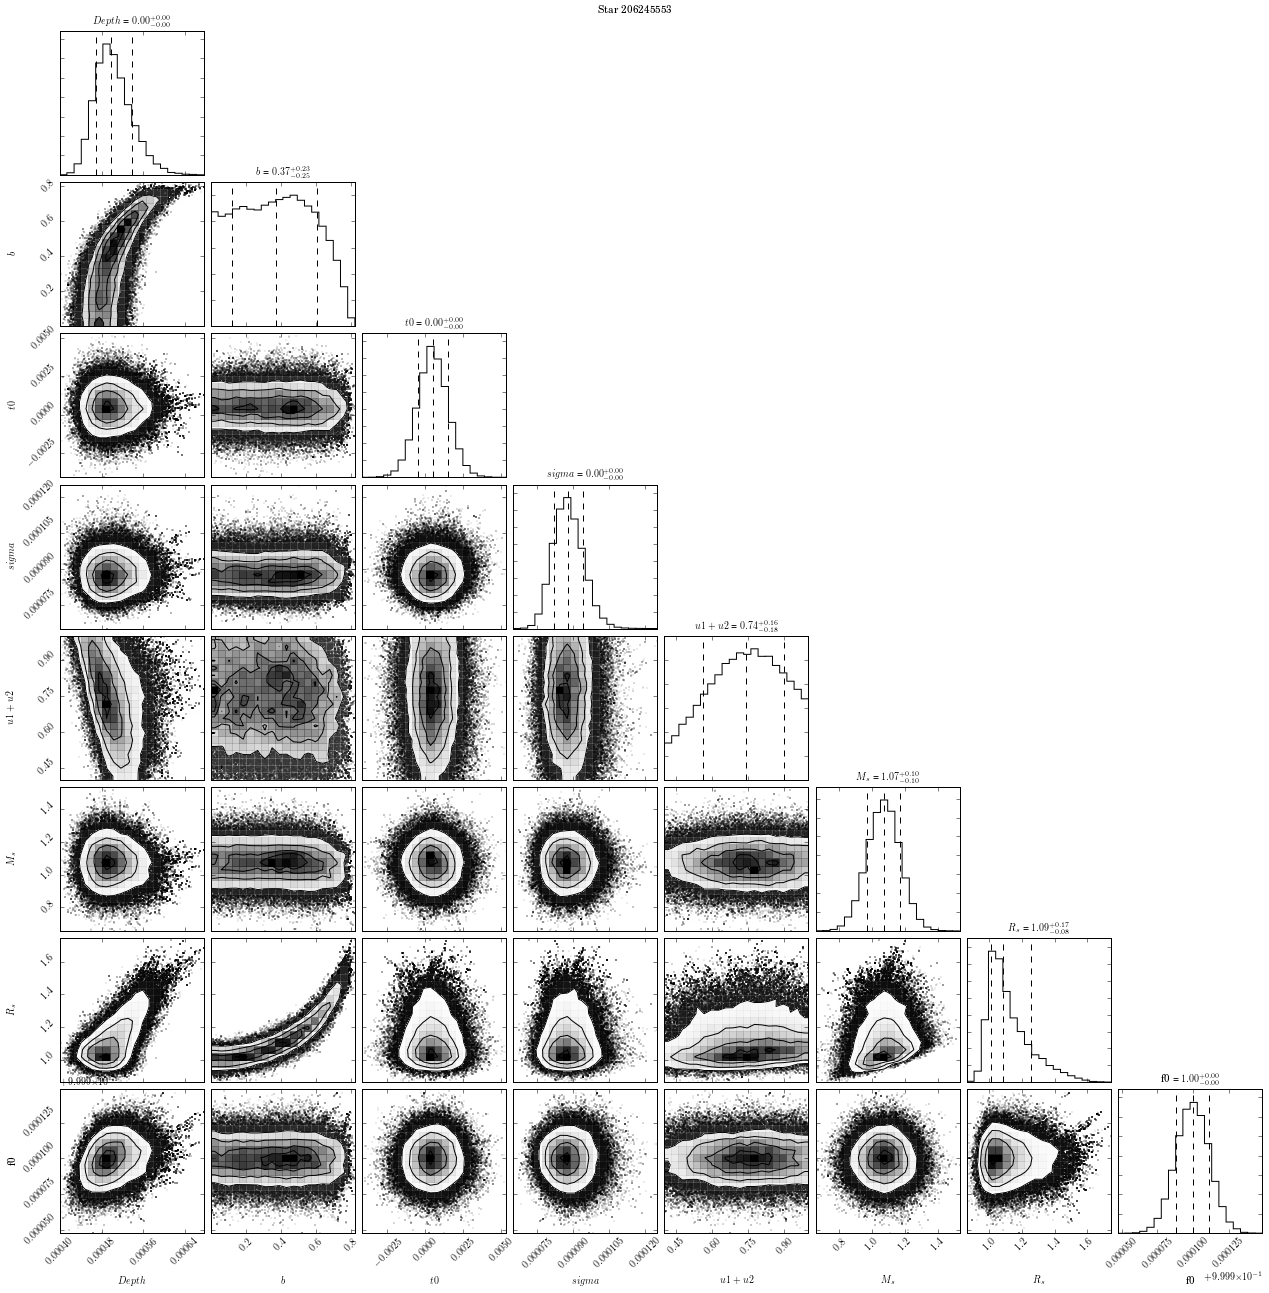

Mean acceptance fraction: 0.280

Autocorrelation time: [ 95.29831931  97.10050276  85.27795746  98.57569194  84.30906022
  94.52067849  94.89268192  94.91219287]
(2.6246046619416461, 0.52492327885255907, 0.21801517594381803)
(0.0656528372765708, 0.010491141446180449, 0.0042638610225370563)

----------------------------------------------------------------------------------------------------


In [23]:
G = 6.6730e-11

for star in new_targets:   
    if (star.name == "201516974") or (star.name == "206061524") or (star.name == "206245553"):
        
        print "Analysis of:", star.name
        print "Model parameters:" 
        print "      Depth:", star.optimize4[0]
        print "      Impact parameter b:", star.optimize4[1]
        print "      Initial transit time:", star.optimize4[2]        
        print "      Sigma:", star.optimize4[3]
        print "      Sum of quadratic LD coefficients:", star.optimize4[4]
        print "      Mass of the star (Earth units):", star.optimize4[5]
        print "      Radius of the star (Earth units):", star.optimize4[6]
        print "      Out-of-transit Flux:", star.optimize4[7]
        print ""

        allfixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]

        # We'll sample a 8-dimensional Gaussian with "nwalkers" walkers.
        ndim = 8
        nwalkers = 100
        st = 9000
        burnin = 5000 # Burn in

        # Choose an initial set of positions for the walkers.
        p0 = [star.optimize4*(1+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]

        # Initialize the sampler with the chosen specs.
        sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                        lnprob, 
                                        args = (star.dt, star.f_trans, 0.01*star.error_foldedLC, allfixed))

        print("Running MCMC...")
        sampler.run_mcmc(p0, st)
        print("Done.")

        # "sampler.chain" is an array with the shape (nwalkers, st, ndim).
        samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)) 

        # Helpful to decide burnin
        plt.clf()
        fig, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 9))
        axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4) #depth = 0
        axes[0].set_ylabel("depth")

        axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
        axes[1].set_ylabel("$b$")

        axes[2].plot((sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
        axes[2].set_ylabel("$t0$")

        axes[3].plot((sampler.chain[:, :, 3]).T, color="k", alpha=0.4)
        axes[3].set_ylabel("sigma")

        axes[4].plot((sampler.chain[:, :, 4]).T, color="k", alpha=0.4)
        axes[4].set_ylabel("$u1+u2$")

        axes[5].plot((sampler.chain[:, :, 5]).T, color="k", alpha=0.4)
        axes[5].set_ylabel("$M_s$")

        axes[6].plot((sampler.chain[:, :, 6]).T, color="k", alpha=0.4)
        axes[6].set_ylabel("$R_s$")

        axes[7].plot((sampler.chain[:, :, 7]).T, color="k", alpha=0.4)
        axes[7].set_ylabel("$f0$")
        axes[7].set_xlabel("step number")

        fig.tight_layout(h_pad=0.0)
        fig.savefig('4_'+star.name+'_line-time.png', dpi = 400)
        plt.show()

        # Make a corner plot.
        plt.figure(2)
        fig = corner.corner(samples, labels=["$Depth$", "$b$", "$t0$", "$sigma$", "$u1+u2$", "$M_s$","$R_s$", "f0"], 
                               quantiles = [0.16, 0.5, 0.84], show_titles = True, title_args={"fontsize": 13})

        fig.gca().annotate('Star '+star.name, xy = (0.5, 1.0), 
                              xycoords="figure fraction", xytext=(0, -5), 
                              textcoords="offset points", ha = "center", va="top")

        fig.savefig('4_'+star.name+'_corner.png', dpi = 400)    
        plt.show()

        # mean acceptance_fraction has an entry for each walker so, it's an "nwalker"-dimensional vector. 
        # This nº should be b/w approx. 0.25 & 0.5 if everything went as planned.

        print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))) 
        print ""


        # Estimate autocorrelation time for the chain. Vector with 8 entries (one for each dimension of the space).

        print "Autocorrelation time:", sampler.acor

        # Calculate the uncertainties based on the 16, 50th, and 84th percentiles of the samples in the marginalized distributions.         

        samples[:, 3] = np.sqrt(samples[:, 3]**2 + 0.01*star.error_foldedLC**2) # I added this line so that the reported uncertainty is the full error of the flux (error_foldedLC was just a guess). 


        # Infer properties of the system
        planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]
        P1 = star.per*24.0*3600.0
        r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

        depth_mcmc, b_mcmc, t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.84, 50, 84.16], axis=0)))

        v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
        planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

        v = np.percentile(r_asamp, [16, 50, 84], axis=0)
        r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

        print planetrad_mcmc # The planet radius in units of the Earth's radius and its +- errors.
        print r_a_mcmc # The inverse of the scaled semi-major axis

        np.savetxt('4_'+star.name+'finalparams.txt', 
                   (depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc, planetrad_mcmc, r_a_mcmc), fmt='%.11f', delimiter='   ', header = """Parameters obtained from fitting the Kepler data. 
                               The 1st column represents the 50% percentile of the MCMC posterior distribution. The 2nd and 3rd show the +1 and -1 sigma errors, respectively. 
                               In row order, the parameters are: Depth, Impact parameter, time of transit, sigma (full error), 
                               Sum of LD coefficients, Mass of the star (Solar units), Radius of the star (Solar units), the 
                               out of eclipse flux, Planet radius (Earth units), R_s/a (Inverse of scaled semi-major axis)""")

        print ""
        print "----------------------------------------------------------------------------------------------------"